# Plot discharge figure
Plot comparison between observed and Flux-PIHM and Cycles-L predicted discharge at the WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pihm import read_output
from pihm import read_mesh
from my_funcs import nse
from setting import WE38_DISCHARGE_OBS
from setting import CYCLES_WATER
from setting import MS_DIR

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

## Read observations

In [3]:
df = pd.read_csv(
    WE38_DISCHARGE_OBS,
    delimiter=',',
    skipinitialspace=True,
    usecols=[1, 2],
    header=0,
    names=['date', 'q'],
    parse_dates=['date'],
)
df = df.sort_values('date')
df.set_index('date', inplace=True)

# Calculate 7-day mean
obs = df.rolling('7d', min_periods=3, center=True, win_type=None).mean()
obs.dropna(inplace=True)
obs.drop(obs[obs.index < datetime(2000, 1, 1)].index, inplace=True)
obs['doy'] = obs.index.dayofyear

## Read Cycles output

In [4]:
_, _, tri, x, y, _, _ = read_mesh('..', 'WE38')

area = [0.5 * ((x[t[1]] - x[t[0]]) * (y[t[2]] - y[t[0]]) - (y[t[1]] - y[t[0]]) * (x[t[2]] - x[t[0]])) for t in tri]
print(area := sum(area))

cycles_df = pd.read_csv(
    CYCLES_WATER,
    usecols=[0,2,4],
    parse_dates=['date'],
)
cycles_df = cycles_df.set_index('date')
cycles_df['q'] = (cycles_df['runoff'] + cycles_df['drainage']) * area / 86400 / 1000
merged = obs.join(cycles_df, how='inner', lsuffix='_obs', rsuffix='_sim')
print(merged.mean() * 86400 * 365 / area)
print('NSE', nse(merged['q_obs'], merged['q_sim']))


7415875.050000034
q_obs         0.442419
doy         759.679964
runoff        1.635735
drainage      5.382330
q_sim         0.602374
dtype: float64
NSE -1.9618404584257108


## Plot

WE38 DOY NSE 0.6839846298580787
WE38_hydro DOY NSE 0.5562635362624415


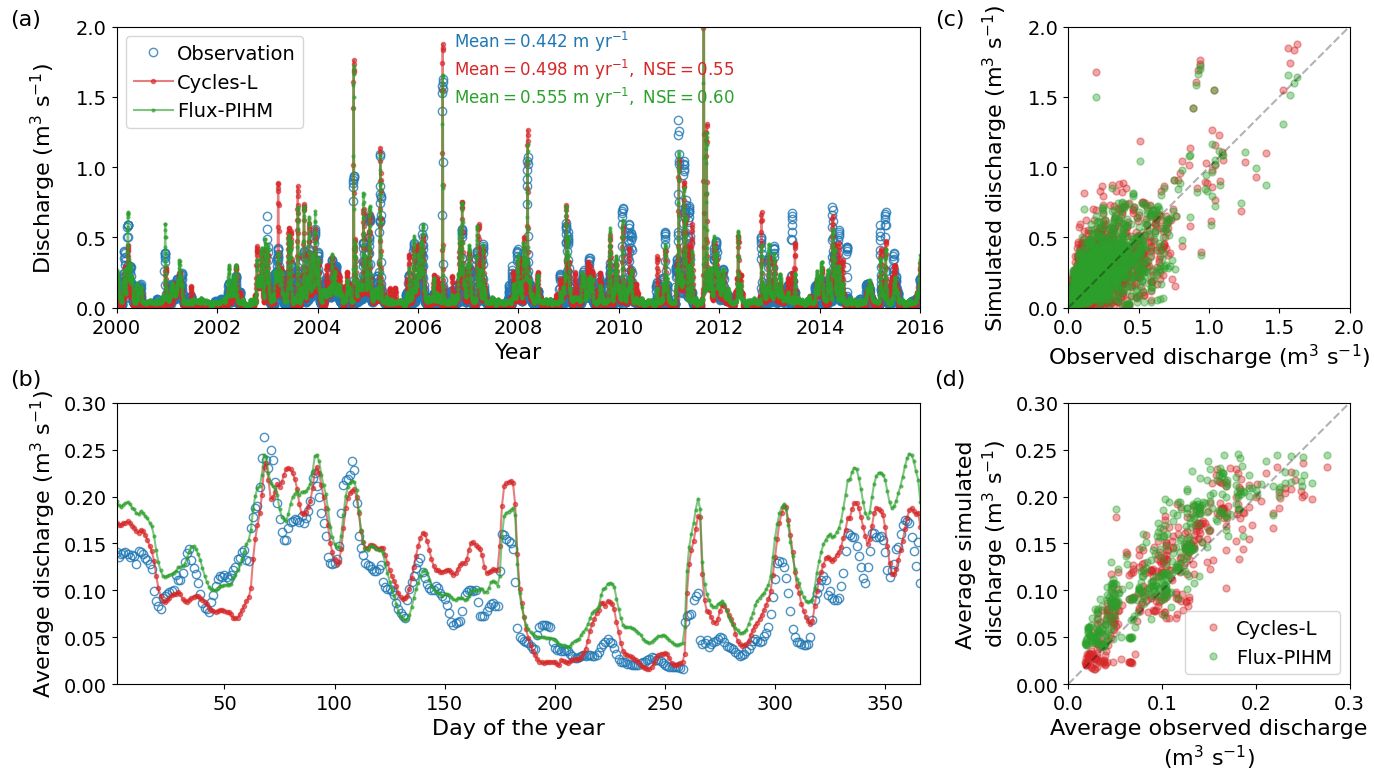

In [5]:
scenarios = {
    "WE38": ["Cycles-L", "#D62728", 6],
    "WE38_hydro": ["Flux-PIHM", "#2CA02C", 4],
}

fig = plt.figure(figsize=(14, 8))

nses = {}
means = {}
lines = []
dots = []
axs = []
axs.append(fig.add_subplot(2, 3, (1, 2)))
axs.append(fig.add_subplot(2, 3, (4, 5)))
axs.append(fig.add_subplot(2, 3, 3))
axs.append(fig.add_subplot(2, 3, 6))

# Plot daily discharge observation
_line, = axs[0].plot(
    obs.index, obs['q'],
    'o',
    color="#1F77B4",
    mfc='none',
    alpha=0.8,
    label='Observation',
)
#_line, = axs[0].plot(
#    obs.index, obs['q'],
#    #'o',
#    color="#1F77B4",
#    alpha=0.3,
#    label='Observation',
#)
lines.append(_line)

# Plot discharge observation averaged to each day of year
obs_doy = obs.groupby(obs['doy']).mean()

axs[1].plot(
    obs_doy.index,
    obs_doy['q'],
    'o',
    color="#1F77B4",
    alpha=0.8,
    mfc='none',
)
#axs[1].plot(
#    obs_doy.index,
#    obs_doy['q'],
#    #'o',
#    color="#1F77B4",
#    alpha=0.3,
#)

xpos = 0.42
ypos = 0.95
for s in scenarios:
    # Read simulations
    sim_time, _q, _, unit = read_output('../', 'WE38', s, 'river.flx1')
    # Adjust time offset
    sim_time -= timedelta(days=1)
    simulation = pd.DataFrame({'q': _q[:, 0], 'date': sim_time})
    simulation.set_index('date', inplace=True)
    # Calculate 7-day mean
    simulation = simulation.rolling('7d', min_periods=3, center=True, win_type=None).mean()
    simulation.dropna(inplace=True)

    # Plot one-to-one comparison between observation and simulation
    merged = obs.join(simulation, how='inner', lsuffix='_obs', rsuffix='_sim')
    means['obs'] = merged['q_obs'].mean() * 86400 * 365 / area
    nses[s] = nse(merged['q_obs'], merged['q_sim'])
    means[s] = merged.mean()['q_sim'] * 86400 * 365 / area

    _dot, = axs[2].plot(merged["q_obs"], merged["q_sim"],
        "o",
        color=scenarios[s][1],
        ms=5,
        alpha=0.4,
        label=scenarios[s][0]
    )
    dots.append(_dot)

    merged = merged.groupby(merged['doy']).mean()
    axs[3].plot(merged["q_obs"], merged["q_sim"],
        "o",
        color=scenarios[s][1],
        alpha=0.4,
        ms=5,
        label=scenarios[s][0]
    )
    print(s, 'DOY NSE', nse(merged['q_obs'], merged['q_sim']))

    # Plot daily discharge simulation    
    _line, = axs[0].plot(simulation.index, simulation['q'],
        ".-",
        color=scenarios[s][1],
        alpha=0.6,
        ms=scenarios[s][2],
        label=scenarios[s][0]
    )
    lines.append(_line)

    # Plot discharge simulation averaged to each day of year
    axs[1].plot(merged.index, merged['q_sim'],
        '.-',
        color=scenarios[s][1],
        alpha=0.6,
        ms=scenarios[s][2],
        label=scenarios[s][0]
    )

# Set x and y axis labels
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Discharge (' + unit + ')')

## Clean up the x axis dates
axs[0].set_ylim(0, 2)
axs[0].set_xlim(datetime(2000, 1, 1), datetime(2016, 1, 1))
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axs[1].set_xlim(1, 366)
axs[1].set_ylim(0, 0.3)
# Set x and y axis labels
axs[1].set_xlabel('Day of the year')
axs[1].set_ylabel('Average discharge (m$^3$ s$^{-1}$)')

axs[0].legend(
    handles=lines,
    loc='upper left',
    handletextpad=0.2,
)
axs[3].legend(
    handles=dots,
    loc='lower right',
    handletextpad=0.2,
)

axs[2].plot([0, 5], [0, 5], 'k--', alpha=0.3)
# Set x and y axis labels
axs[2].set_xlabel('Observed discharge (' + unit + ')')
axs[2].set_ylabel('Simulated discharge (' + unit + ')')

## Clean up the x axis dates
axs[2].set_ylim(0, 2)
axs[2].set_xlim(0, 2)
axs[2].set_aspect("equal")

axs[3].plot([0, 5], [0, 5], 'k--', alpha=0.3)
axs[3].set_xlabel('Average observed discharge\n(' + unit + ')')
axs[3].set_ylabel('Average simulated\ndischarge (' + unit + ')')
axs[3].set_ylim(0, 0.3)
axs[3].set_xlim(0, 0.3)
axs[3].set_aspect("equal")

plt.tight_layout()
fig.align_ylabels(axs)

plt.text(
    xpos, ypos, 
    f'$\mathrm{{Mean}} = {means["obs"]:.3f}\mathrm{{~m~yr}}^{{-1}}$',
    color='#1F77B4',
    size=12,
    ha='left', 
    va='center', 
    transform=axs[0].transAxes,
)
ypos = ypos - 0.1
for s in scenarios:
    plt.text(
        xpos, ypos, 
        f'$\mathrm{{Mean}} = {means[s]:.3f}\mathrm{{~m~yr}}^{{-1}}\mathrm{{,~NSE}} = {nses[s]:.2f}$',
        color=scenarios[s][1],
        size=12,
        ha='left', 
        va='center', 
        transform=axs[0].transAxes,
    )
    ypos = ypos - 0.1

fig.text(0.015, 0.97,'(a)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.97,'(c)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.015, 0.52,'(b)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.52,'(d)', ha='center', va='center', transform=fig.transFigure)
fig.savefig(f'{MS_DIR}/figures/discharge.png', dpi=300)
fig.savefig(f'{MS_DIR}/latex/discharge.pdf', dpi=300)